### This file is for AFTER Google Colab updated on 2023-07-21
Important things to note:
1. Colab's Ubuntu upgraded from 20.04 LTS to 22.04 LTS
2. Colab's CUDA upgraded, and downgrading it was impossible due to Ubuntu's upgrade.

These changes required use of the latest MXNet package made for cuda 11.2, `mxnet-cu112`,
which worked on the newer version. Also, MXNet became officially archived.

In [ ]:
# searching for if the scikit packages are installed
!pip list | grep -E "scikit|sk"

dask                             2023.8.1
diskcache                        5.6.3
Flask                            2.2.5
multitasking                     0.0.11
scikit-image                     0.19.3
scikit-learn                     1.2.2
sklearn-pandas                   2.2.0


In [ ]:
import numpy as np
import pandas as pd

## google drive import

In [ ]:
!ls

sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp 'drive/MyDrive/Colab Notebooks Project/jingjinji.csv' .
!cp 'drive/MyDrive/Colab Notebooks Project/aq_.csv' .

## Training / testing cities

In [ ]:
# Some variables used later on
SEQ_LENGTH = 7
NUM_NEIGHBORS = 3

_DRIVE_ROOT_FLDR = 'drive/MyDrive/Colab Notebooks Project/'

STD_COLS = ['PM25', 'PM10', 'CO', 'NO2', 'O3_8', 'SO2']
y_feature = 'PM25'
x_features = list(set(STD_COLS) - {y_feature}) \
              + ['WS.max', 'WD.max']
print('sequence length:', SEQ_LENGTH)
print('number of neighbors:', NUM_NEIGHBORS)
print('y_feature:', y_feature)
print('x_features:', x_features)

TRAIN_CITIES_PERCENT = 0.25  # first 25% of the list (below) will be the training cities

# order randomized
citycodes_list = [
    131000,
    410100,
    370100,
    120000,
    130500,
    370800,
    130900,
    140400,
    130200,
    130600,
    410800,
    130400,
    140100,
    410600,
    140300,
    371700,
    410700,
    370300,
    371500,
    140500,
    410200,
    130100,
    131100,
    410500,
    371400,
    371600,
    410900,
    110000,
]
_cutoff = int( len(citycodes_list) * TRAIN_CITIES_PERCENT )
test_citycode_list = citycodes_list[:_cutoff]
train_citycode_list = citycodes_list[_cutoff:]
del _cutoff
print('number of total cities:', len(citycodes_list))
print(f'train cities ({len(train_citycode_list)}): ', train_citycode_list)
print(f'test cities ({len(test_citycode_list)}): ', test_citycode_list)

sequence length: 7
number of neighbors: 3
y_feature: PM25
x_features: ['SO2', 'CO', 'O3_8', 'PM10', 'NO2', 'WS.max', 'WD.max']
number of total cities: 28
train cities (21):  [140400, 130200, 130600, 410800, 130400, 140100, 410600, 140300, 371700, 410700, 370300, 371500, 140500, 410200, 130100, 131100, 410500, 371400, 371600, 410900, 110000]
test cities (7):  [131000, 410100, 370100, 120000, 130500, 370800, 130900]


## Import sequences from google drive

In [ ]:
!cp -r 'drive/MyDrive/Colab Notebooks Project/prepared_seqs' .
# where traintype is like:
#    > 'together_train_y'
#    > 'together_train_allx'
#    > 'separate_train_y'
#    > 'separate_train_targetx'
#    > 'separate_train_neighborx'
#  and replace 'train' with 'test' for the other case
filename = 'prepared_seqs/{seqtype}_seqs_{num_neighbors}nbrs_seqlen{seq_length}.npy'

In [ ]:
def _npload(seqtype):
    a = None
    with open(filename.format(seqtype=seqtype, num_neighbors=NUM_NEIGHBORS,
                              seq_length=SEQ_LENGTH), 'rb') as f:
        a = np.load(f)
        print(' dtype:', a.dtype)
    return a

import pickle
def _pload(name):
    a = None
    with open(f'prepared_seqs/{name}.pickle', 'rb') as f:
        a = pickle.load(f)
        print('',type(a))
    return a

together_cities_neighbors_dict = _pload('together_cities_neighbors_dict')
together_largestneighbordist = _pload('together_largestneighbordist')

together_train_y_seqs = _npload('together_train_y')
together_train_allx_seqs = _npload('together_train_allx')
together_test_y_seqs = _npload('together_test_y')
together_test_allx_seqs = _npload('together_test_allx')

separate_cities_neighbors_dict = _pload('separated_cities_neighbors_dict')
separate_largestneighbordist = _pload('separated_largestneighbordist')

separate_train_y_seqs = _npload('separated_train_y')
separate_train_targetx_seqs = _npload('separated_train_targetx')
separate_train_neighborx_seqs = _npload('separated_train_neighborx')
separate_test_y_seqs = _npload('separated_test_y')
separate_test_targetx_seqs = _npload('separated_test_targetx')
separate_test_neighborx_seqs = _npload('separated_test_neighborx')

 <class 'dict'>
 <class 'float'>
 dtype: float64
 dtype: float64
 dtype: float64
 dtype: float64
 <class 'dict'>
 <class 'float'>
 dtype: float64
 dtype: float64
 dtype: float64
 dtype: float64
 dtype: float64
 dtype: float64


In [ ]:
print(together_train_y_seqs.shape)
print(together_test_y_seqs.shape)

(22697, 1, 1)
(7547, 1, 1)


### just calculating num of unsafe PM2.5s

In [ ]:
# df, cc_names_dict, cc_latlongsdict = left_join_the_dataframes()
# print(df.head())
# print('df shape:', df.shape)
# print(df.columns)
# COLS = ['PM25','PM10','CO','NO2','SO2','O3_8']
# WS_COL = 'WS.max'
# Y_COL = 'PM25'

In [ ]:
# _dfdropped = df.dropna(subset = COLS + [WS_COL], inplace=False)
# print('df.shape:', df.shape, '; df.shape after this drop:', _dfdropped.shape)
# for col in COLS + [WS_COL]:
#   print(col, 'mean:', _dfdropped[col].values.mean(), '  | on original df:', df[col].values.mean())
#   print(col, 'std:', _dfdropped[col].values.std(), '  | on original df:', df[col].values.std())
#   print(col, 'min:', _dfdropped[col].values.min(), '  | on original df:', df[col].values.min())
#   print(col, 'max:', _dfdropped[col].values.max(), '  | on original df:', df[col].values.max())
# print(_dfdropped.shape)
# _pm25overlimit = _dfdropped[_dfdropped['PM25'].values > 75.0]
# print(_pm25overlimit.head())
# print(_pm25overlimit.shape)
# del _pm25overlimit

In [ ]:
# 6463 / 30678

## Flatten each sequence into one input row. To feed into RFTree.
The Random Forest tree needs a flat row of data as input. So, take for example the 7 * 33 two-dimensional 'together' X data and flatten it into a row of length 231. Same for others.

In [ ]:
print('together:')


print(together_train_y_seqs.shape, end='')
_shape = together_train_y_seqs.shape
assert len(_shape) == 3
together_train_y_seqs = together_train_y_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', together_train_y_seqs.shape)

print(together_train_allx_seqs.shape, end='')
_shape = together_train_allx_seqs.shape
assert len(_shape) == 3
together_train_allx_seqs = together_train_allx_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', together_train_allx_seqs.shape)

print(together_test_y_seqs.shape, end='')
_shape = together_test_y_seqs.shape
assert len(_shape) == 3
together_test_y_seqs = together_test_y_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', together_test_y_seqs.shape)

print(together_test_allx_seqs.shape, end='')
_shape = together_test_allx_seqs.shape
assert len(_shape) == 3
together_test_allx_seqs = together_test_allx_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', together_test_allx_seqs.shape)


print('separate:')


print(separate_train_y_seqs.shape, end='')
_shape = separate_train_y_seqs.shape
assert len(_shape) == 3
separate_train_y_seqs = separate_train_y_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', separate_train_y_seqs.shape)

print(separate_train_targetx_seqs.shape, end='')
_shape = separate_train_targetx_seqs.shape
assert len(_shape) == 3
separate_train_targetx_seqs = separate_train_targetx_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', separate_train_targetx_seqs.shape)

print(separate_train_neighborx_seqs.shape, end='')
_shape = separate_train_neighborx_seqs.shape
assert len(_shape) == 3
separate_train_neighborx_seqs = separate_train_neighborx_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', separate_train_neighborx_seqs.shape)

print(separate_test_y_seqs.shape, end='')
_shape = separate_test_y_seqs.shape
assert len(_shape) == 3
separate_test_y_seqs = separate_test_y_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', separate_test_y_seqs.shape)

print(separate_test_targetx_seqs.shape, end='')
_shape = separate_test_targetx_seqs.shape
assert len(_shape) == 3
separate_test_targetx_seqs = separate_test_targetx_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', separate_test_targetx_seqs.shape)

print(separate_test_neighborx_seqs.shape, end='')
_shape = separate_test_neighborx_seqs.shape
assert len(_shape) == 3
separate_test_neighborx_seqs = separate_test_neighborx_seqs.reshape(_shape[0], _shape[1] * _shape[2])
print('  -> ', separate_test_neighborx_seqs.shape)


together:
(22697, 1, 1)  ->  (22697, 1)
(22697, 7, 33)  ->  (22697, 231)
(7547, 1, 1)  ->  (7547, 1)
(7547, 7, 33)  ->  (7547, 231)
separate:
(22697, 1, 1)  ->  (22697, 1)
(22697, 7, 6)  ->  (22697, 42)
(22697, 7, 27)  ->  (22697, 189)
(7547, 1, 1)  ->  (7547, 1)
(7547, 7, 6)  ->  (7547, 42)
(7547, 7, 27)  ->  (7547, 189)


## Perform RFTree

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# scikit-learn modules
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

### Util functions

In [ ]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    # Adapted from https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python

    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor=None)

    return ax

In [ ]:
import scipy.stats as stats
def plot_ci_manual_with(x, y, ax):
    # Adapted from https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python

    p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = np.polyval(p, x)                                 # model using the fit parameters; NOTE: parameters here are coefficients

    # Statistics
    n = x.size                                                 # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                                        # residuals; diff. actual data from predicted values
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = np.polyval(p, x2)

    # Confidence Interval
    plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)

    # Prediction Interval
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
    ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
    ax.plot(x2, y2 + pi, "--", color="0.5")

In [ ]:
means_stds_dict = {'PM25': [56.448841226897876, 42.8382211400005]}  # copied out from presequencing_means_stds_dict.json
# unstandardize PM2.5
def _unstdize(ys):
  _pm25mean, _pm25std = means_stds_dict['PM25']
  return (ys*_pm25std)+_pm25mean

In [ ]:
def plot_r2(all_y_pred, all_y, ax):
    _x = _unstdize(all_y_pred)
    _y = _unstdize(all_y)

    ax.axline((0,0), slope=1, color='gray')
    ax.scatter(_x, _y, s=4, alpha=0.4,)

    _lob = np.poly1d(np.polyfit(_x, _y, deg=1))
    print(_lob)
    ax.axline((0,_lob[0]), slope=_lob[1], color='orange', linestyle='dashed', linewidth=1.5)

    plot_ci_manual_with(_x, _y, ax)

### Together (n = 3)

Using the *together* X, as it's all one X array

In [ ]:
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 10, random_state = 0)

x_train = together_train_allx_seqs
y_train = together_train_y_seqs.ravel()
x_test = together_test_allx_seqs
y_test = together_test_y_seqs.ravel()

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

# Predicting the target values of the test set
y_pred = model.predict(x_test)

# RMSE (Root Mean Square Error)
mse = mean_squared_error(y_test, y_pred)
# rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)),'.3f'))
print("\nMSE:\n",format(mse,'.3f'))
# print("\nRMSE:\n",rmse)
print("\nRMSE:\n",format(np.sqrt(mse),'.3f'))


MSE:
 0.368

RMSE:
 0.607


In [ ]:
MSEs = []
fittimes = []
import time
n_estimators = [1,2,3,5,10,15,20] + [30,50,70,100] + [150,200,250]
R2s = []

In [ ]:
for n_estims in n_estimators[:7]: # [1,2,3,5,10,15,20]
    # Initializing the Random Forest Regression model with 10 decision trees
    # model = RandomForestRegressor(n_estimators = 10, random_state = 0)
    model = RandomForestRegressor(n_estimators = n_estims, random_state = 0)

    x_train = together_train_allx_seqs
    y_train = together_train_y_seqs.ravel()
    x_test = together_test_allx_seqs
    y_test = together_test_y_seqs.ravel()

    _start = time.time()
    # Fitting the Random Forest Regression model to the data
    model.fit(x_train, y_train)
    _stop = time.time()

    # Predicting the target values of the test set
    y_pred = model.predict(x_test)

    # RMSE (Root Mean Square Error)
    mse = mean_squared_error(y_test, y_pred)

    print(f"n_estimators={n_estims}:")
    print("  MSE:\n ",format(mse,'.3f'))
    print("  RMSE:\n ",format(np.sqrt(mse),'.3f'))


    # r2 score on entire dataset
    all_x = np.concatenate([separate_train_targetx_seqs,
                    separate_test_targetx_seqs], axis=0)
    all_y = np.concatenate([separate_train_y_seqs,
                    separate_test_y_seqs], axis=0).ravel()
    all_y_pred = model.predict(all_x)

    r2 = r2_score(all_y, all_y_pred)
    print("  R2:\n ",format(r2,'.3f'))
    print("  R2 (manual):\n ",format(
        1 - (np.square(all_y - all_y_pred).sum() /
             np.square(all_y - all_y.mean()).sum()),'.3f'))

    MSEs.append(mse)
    fittimes.append(_stop-_start)

    R2s.append(r2)

n_estimators=1:
  MSE:
  0.778
  RMSE:
  0.882
n_estimators=2:
  MSE:
  0.553
  RMSE:
  0.743
n_estimators=3:
  MSE:
  0.470
  RMSE:
  0.686
n_estimators=5:
  MSE:
  0.407
  RMSE:
  0.638
n_estimators=10:
  MSE:
  0.368
  RMSE:
  0.607
n_estimators=15:
  MSE:
  0.355
  RMSE:
  0.596
n_estimators=20:
  MSE:
  0.350
  RMSE:
  0.592


In [ ]:
for n_estims in n_estimators[7:]: # [30,50,70,100] + [150,200,250]
    # Initializing the Random Forest Regression model with 10 decision trees
    # model = RandomForestRegressor(n_estimators = 10, random_state = 0)
    model = RandomForestRegressor(n_estimators = n_estims, random_state = 0)

    x_train = together_train_allx_seqs
    y_train = together_train_y_seqs.ravel()
    x_test = together_test_allx_seqs
    y_test = together_test_y_seqs.ravel()

    _start = time.time()
    # Fitting the Random Forest Regression model to the data
    model.fit(x_train, y_train)
    _stop = time.time()

    # Predicting the target values of the test set
    y_pred = model.predict(x_test)

    # RMSE (Root Mean Square Error)
    mse = mean_squared_error(y_test, y_pred)

    print(f"n_estimators={n_estims}:")
    print("  MSE:\n ",format(mse,'.3f'))
    print("  RMSE:\n ",format(np.sqrt(mse),'.3f'))

    # r2 score on entire dataset
    all_x = np.concatenate([separate_train_targetx_seqs,
                    separate_test_targetx_seqs], axis=0)
    all_y = np.concatenate([separate_train_y_seqs,
                    separate_test_y_seqs], axis=0).ravel()
    all_y_pred = model.predict(all_x)
    
    r2 = r2_score(all_y, all_y_pred)
    print("  R2:\n ",format(r2,'.3f'))
    print("  R2 (manual):\n ",format(
        1 - (np.square(all_y - all_y_pred).sum() /
             np.square(all_y - all_y.mean()).sum()),'.3f'))

    MSEs.append(mse)
    fittimes.append(_stop-_start)

    R2s.append(r2)

n_estimators=30:
  MSE:
  0.342
  RMSE:
  0.585
n_estimators=50:
  MSE:
  0.337
  RMSE:
  0.580
n_estimators=70:
  MSE:
  0.334
  RMSE:
  0.578
n_estimators=100:
  MSE:
  0.332
  RMSE:
  0.576
n_estimators=150:
  MSE:
  0.331
  RMSE:
  0.575
n_estimators=200:
  MSE:
  0.329
  RMSE:
  0.574
n_estimators=250:
  MSE:
  0.329
  RMSE:
  0.574


In [ ]:
print(n_estimators)
print(MSEs)
print(fittimes)
print(R2s)
assert len(n_estimators) == len(MSEs) == len(R2s) == len(fittimes)

[1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 250]
[0.778103561470458, 0.5525573330916652, 0.4701514799539957, 0.40691967030837406, 0.3681731771513319, 0.35519024442852914, 0.35048701129306753, 0.342128935069656, 0.3365827741253844, 0.3344689716935102, 0.33191657960476123, 0.3309495949215502, 0.32903572935569725, 0.32897564580552846]
[3.6622440814971924, 8.401844263076782, 11.652109146118164, 20.888892650604248, 43.080347299575806, 60.93894100189209, 83.47607493400574, 125.44911289215088, 206.67279195785522, 290.9216697216034, 413.42292737960815, 619.8647725582123, 825.0308434963226, 1034.752576828003]


In [ ]:
model_250 = model
model_250

RandomForestRegressor(n_estimators=250, random_state=0)

In [ ]:
all_y_pred = model_250.predict(all_x)
print(all_y_pred.shape, all_y.shape)

In [ ]:
plt.figure(figsize=(5,5))
ax = plt.gca()

plot_r2(all_y_pred, all_y, ax)

## Test of target city only, no neighbors

In [ ]:
print(n_estimators)
# arrays for no-neighbors runs
nn_MSEs = []
nn_fittimes = []
nn_R2s = []

[1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 250]


In [ ]:
for n_estims in n_estimators:
    # Initializing the Random Forest Regression model with 10 decision trees
    # model = RandomForestRegressor(n_estimators = 10, random_state = 0)
    model = RandomForestRegressor(n_estimators = n_estims, random_state = 0)

    x_train = separate_train_targetx_seqs
    y_train = separate_train_y_seqs.ravel()
    x_test = separate_test_targetx_seqs
    y_test = separate_test_y_seqs.ravel()

    _start = time.time()
    # Fitting the Random Forest Regression model to the data
    model.fit(x_train, y_train)
    _stop = time.time()

    # Predicting the target values of the test set
    y_pred = model.predict(x_test)

    # RMSE (Root Mean Square Error)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"n_estimators={n_estims}:")
    print("  MSE:\n ",format(mse,'.3f'))
    print("  RMSE:\n ",format(np.sqrt(mse),'.3f'))

    # r2 score on entire dataset
    all_x = np.concatenate([separate_train_targetx_seqs,
                    separate_test_targetx_seqs], axis=0)
    all_y = np.concatenate([separate_train_y_seqs,
                    separate_test_y_seqs], axis=0).ravel()

    all_y_pred = model.predict(all_x)

    r2 = r2_score(all_y, all_y_pred)
    print("  R2:\n ",format(r2,'.3f'))
    print("  R2 (manual):\n ",format(
        1 - (np.square(all_y - all_y_pred).sum() /
             np.square(all_y - all_y.mean()).sum()),'.3f'))

    nn_MSEs.append(mse)
    nn_fittimes.append(_stop-_start)

    nn_R2s.append(r2)

n_estimators=1:
  MSE:
  0.823
  RMSE:
  0.907
  R2:
  0.544
  R2 (manual):
  0.544
n_estimators=2:
  MSE:
  0.594
  RMSE:
  0.770
  R2:
  0.703
  R2 (manual):
  0.703
n_estimators=3:
  MSE:
  0.532
  RMSE:
  0.730
  R2:
  0.755
  R2 (manual):
  0.755
n_estimators=5:
  MSE:
  0.491
  RMSE:
  0.701
  R2:
  0.794
  R2 (manual):
  0.794
n_estimators=10:
  MSE:
  0.439
  RMSE:
  0.663
  R2:
  0.828
  R2 (manual):
  0.828
n_estimators=15:
  MSE:
  0.411
  RMSE:
  0.641
  R2:
  0.842
  R2 (manual):
  0.842
n_estimators=20:
  MSE:
  0.401
  RMSE:
  0.633
  R2:
  0.849
  R2 (manual):
  0.849
n_estimators=30:
  MSE:
  0.393
  RMSE:
  0.627
  R2:
  0.854
  R2 (manual):
  0.854
n_estimators=50:
  MSE:
  0.384
  RMSE:
  0.619
  R2:
  0.859
  R2 (manual):
  0.859
n_estimators=70:
  MSE:
  0.380
  RMSE:
  0.616
  R2:
  0.861
  R2 (manual):
  0.861
n_estimators=100:
  MSE:
  0.379
  RMSE:
  0.615
  R2:
  0.863
  R2 (manual):
  0.863
n_estimators=150:
  MSE:
  0.376
  RMSE:
  0.613
  R2:
  0.864
  R2 

In [ ]:
print('No neighbors:')
print(n_estimators)
print('nn_MSEs=', nn_MSEs)
print('nn_R2s=', nn_R2s)
print('nn_fittimes=', nn_fittimes)
assert len(n_estimators) == len(nn_MSEs) == len(nn_R2s) == len(nn_fittimes)

No neighbors:
[1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 250]
nn_MSEs= [0.8231206041172979, 0.5935959799371266, 0.532405405227376, 0.4908189051650815, 0.4389844849315258, 0.4111064153593869, 0.40107284548885835, 0.3929504519072606, 0.38370136852677644, 0.3799181317063233, 0.37858326216467575, 0.3763776222416787, 0.37621333021129066, 0.37619002166255844]
nn_R2s= [0.5439591387875848, 0.7028288075733238, 0.7550810454043546, 0.7944277815898289, 0.8277980199812953, 0.8420203909738331, 0.8485655036444276, 0.8536663125880586, 0.8591654434048924, 0.8612700232936115, 0.8626989621331884, 0.8639683758745446, 0.8643489693649866, 0.8646003077524429]
nn_fittimes= [1.0122120380401611, 2.0717177391052246, 2.9440994262695312, 3.562774658203125, 6.9522528648376465, 12.314955711364746, 15.572060823440552, 22.236918210983276, 39.81978106498718, 55.590740442276, 75.95424270629883, 116.22202014923096, 153.216694355011, 187.24497628211975]


In [ ]:
model_250_nn = model
model_250_nn

RandomForestRegressor(n_estimators=250, random_state=0)

In [ ]:
all_y_pred = model_250_nn.predict(all_x)
print(all_y_pred.shape, all_y.shape)

(30244,) (30244,)


 
1.111 x - 6.924


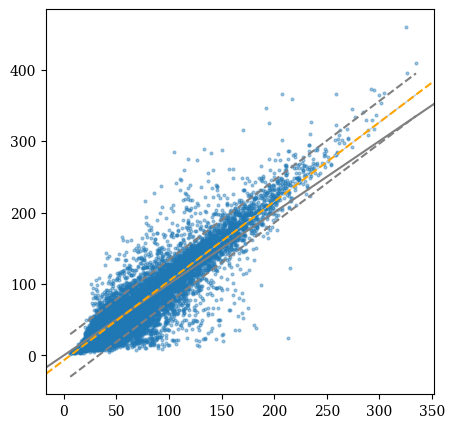

In [ ]:
plt.figure(figsize=(5,5))
ax = plt.gca()

plot_r2(all_y_pred, all_y, ax)

# Plot

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [ ]:
n_estimators = [1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100]
MSEs = [0.778103561470458, 0.5525573330916652, 0.4701514799539957, 0.40691967030837406, 0.3681731771513319, 0.35519024442852914, 0.35048701129306753, 0.342128935069656, 0.3365827741253844, 0.3344689716935102, 0.33191657960476123]
fittimes = [4.005464553833008, 12.876124858856201, 15.25211477279663, 21.008296489715576, 42.09202265739441, 76.4133722782135, 83.30763792991638, 133.57892107963562, 204.0920271873474, 285.05224323272705, 407.0427098274231]


In [ ]:
n_estimators = [1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100, 150, 200, 250]
MSEs = [0.778103561470458, 0.5525573330916652, 0.4701514799539957, 0.40691967030837406, 0.3681731771513319, 0.35519024442852914, 0.35048701129306753, 0.342128935069656, 0.3365827741253844, 0.3344689716935102, 0.33191657960476123, 0.3309495949215502, 0.32903572935569725, 0.32897564580552846]
fittimes = [3.6622440814971924, 8.401844263076782, 11.652109146118164, 20.888892650604248, 43.080347299575806, 60.93894100189209, 83.47607493400574, 125.44911289215088, 206.67279195785522, 290.9216697216034, 413.42292737960815, 619.8647725582123, 825.0308434963226, 1034.752576828003]


In [ ]:
nn_MSEs= [0.8231206041172979, 0.5935959799371266, 0.532405405227376, 0.4908189051650815, 0.4389844849315258, 0.4111064153593869, 0.40107284548885835, 0.3929504519072606, 0.38370136852677644, 0.3799181317063233, 0.37858326216467575, 0.3763776222416787, 0.37621333021129066, 0.37619002166255844]
nn_fittimes= [0.7002596855163574, 1.772799015045166, 2.8896286487579346, 4.2069501876831055, 6.594956636428833, 12.108967304229736, 15.408120393753052, 21.92256474494934, 37.258371353149414, 52.590044260025024, 76.34419560432434, 111.58469605445862, 150.88367772102356, 187.85901308059692]
nn_R2s= [0.5439591387875848, 0.7028288075733238, 0.7550810454043546, 0.7944277815898289, 0.8277980199812953, 0.8420203909738331, 0.8485655036444276, 0.8536663125880586, 0.8591654434048924, 0.8612700232936115, 0.8626989621331884, 0.8639683758745446, 0.8643489693649866, 0.8646003077524429]

Text(0.5, 1.0, 'Random Forest Tree error trends')

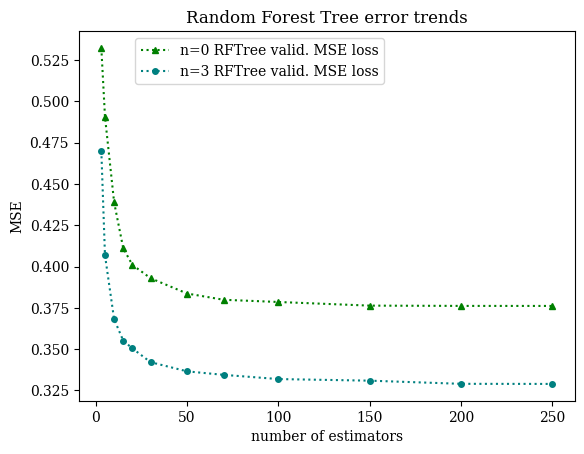

In [ ]:
axes1: plt.Axes = plt.gca()
fig = axes1.figure
axes1.set_xlabel('number of estimators')
axes1.set_ylabel('MSE')

# no-neighbors (n=0) :
axes1.plot(n_estimators[2:], nn_MSEs[2:], markersize=4,
          color='green', marker='^', #marker='o',
          linestyle='dotted',
          label='n=0 RFTree valid. MSE loss')

# neighbors (n=3) :
axes1.plot(n_estimators[2:], MSEs[2:], markersize=4,
          color='teal', marker='o', #marker='o',
          linestyle='dotted',
          label='n=3 RFTree valid. MSE loss')

fig.legend(loc='upper left', bbox_to_anchor=(0.1,0,1,1), bbox_transform=axes1.transAxes)
plt.title('Random Forest Tree error trends')


Text(0.5, 1.0, 'Random Forest Tree error trend')

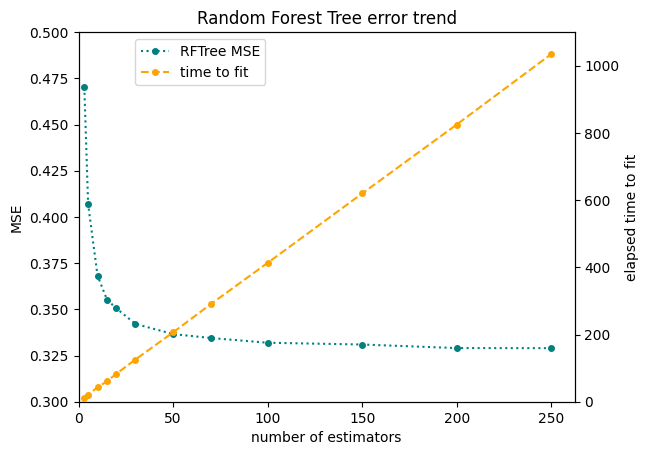

In [ ]:
axes1: plt.Axes = plt.gca()
fig = axes1.figure
axes1.set_xlabel('number of estimators')
axes2 = axes1.twinx()
axes1.set_ylabel('MSE')
axes2.set_ylabel('elapsed time to fit')
axes2.plot(n_estimators[2:], fittimes[2:], markersize=4,
          color='orange', marker='o', #marker='+',
          linestyle='dashed',
          label='time to fit')
axes1.plot(n_estimators[2:], MSEs[2:], markersize=4,
          color='teal', marker='o', #marker='o',
          linestyle='dotted',
          label='RFTree MSE')

axes1.set_ylim(0.3,0.5)
axes2.set_ylim(0,1100)
axes1.set_xlim(0,None)

fig.legend(loc='upper left', bbox_to_anchor=(0.1,0,1,1), bbox_transform=axes1.transAxes)
plt.title('Random Forest Tree error trend')


In [ ]:
training_time = [
    38.2524, 38.0899, 37.5977, 37.8646, 37.6870, 38.2137, 39.0228, 38.3660, 38.0299, 37.3258, 38.6453, 37.6755, 39.0312, 37.6135, 38.0636, 38.0761, 38.7156, 41.0013, 37.5903, 38.4472, 37.4341, 38.5487, 37.2673, 37.5993, 36.6466, 37.9384, 36.9369, 37.1224, 37.4667, 37.9149, 38.0447, 38.0568, 37.4959, 37.9181, 37.6905, 37.4546, 37.2207, 37.0392, 37.3220, 37.5951
]
testing_time = [
    11.0947, 11.3354, 10.9400, 11.3956, 10.5516, 11.1600, 10.3318, 11.3184, 10.8106, 11.4194, 11.1181, 11.2963, 11.3620, 11.4946, 11.3684, 10.5933, 11.5515, 11.3059, 11.5667, 11.5106, 10.9835, 11.3288, 10.6504, 11.2051, 11.1583, 11.1822, 10.5356, 11.1930, 10.5394, 11.4539, 10.5605, 11.2823, 10.4295, 11.1052, 10.4009, 11.1986, 10.5987, 11.2747, 10.7093, 11.6379
]
total_times = [t+v for t,v in zip(training_time,testing_time)]
train_losses = [0.36156967843024923, 0.32262193192179833, 0.2926159213301007, 0.2628182589413317, 0.23751681174136505, 0.2147840507406613, 0.20337492112303973, 0.19618382207524895, 0.19358890484398267, 0.19087518440999898, 0.18812352844213356, 0.18555612306401312, 0.1829920872231096, 0.18103184213355142, 0.178693318141541, 0.17726932950002824, 0.17574779192598405, 0.1745781510046695, 0.17218814600087437, 0.17122766436825862, 0.16945777711877894, 0.16793427908298553, 0.1670774591071341, 0.16551346737967568, 0.16370248771079804, 0.16335344025776594, 0.16184632689126002, 0.1600890057684868, 0.1590495164864818, 0.15829799121699917, 0.15726446917166026, 0.15604825071073936, 0.15530559164791882, 0.15509341602654073, 0.15323341954780062, 0.1521768845836655, 0.15230034886930896, 0.1508061726760694, 0.14976082114279063, 0.14956841231904625]
test_losses = [0.3507515992401555, 0.3174818160748759, 0.29428038657121125, 0.264955095258798, 0.2293252271596458, 0.21512148739839626, 0.20996391243702345, 0.196019194045723, 0.20909174880747294, 0.20648704042224708, 0.18400300558979038, 0.19572757371311444, 0.17782811107496532, 0.17628777837918952, 0.19159799585790965, 0.1920833965773951, 0.17078495238775715, 0.16863161994969975, 0.1683604804630942, 0.19740785479527873, 0.1732546684440157, 0.16831213983883025, 0.1722394631233905, 0.17949594260036547, 0.16987296959340645, 0.19410089747365755, 0.1773421145082826, 0.17535296092751693, 0.17782913297257263, 0.16219778525970555, 0.17308074098432844, 0.15373918294418967, 0.16967184096433777, 0.16272801484593005, 0.15807321030988508, 0.16133814394515705, 0.15631373266908036, 0.16704526188488986, 0.14817161520821953, 0.17651816280499635]
assert len(training_time) == len(testing_time) == 40
assert len(total_times) == 40
assert len(train_losses) == len(test_losses) == 40
running_times = [sum(total_times[:i+1]) for i,t in enumerate(total_times)]
print(total_times)
print(running_times)
# total time diff for train() call, all epochs: 1958.9957 sec (hh:mm:ss 00:32:38.996)

[49.3471, 49.4253, 48.5377, 49.260200000000005, 48.2386, 49.3737, 49.3546, 49.6844, 48.8405, 48.7452, 49.7634, 48.9718, 50.3932, 49.1081, 49.432, 48.669399999999996, 50.2671, 52.3072, 49.157, 49.957800000000006, 48.4176, 49.8775, 47.917699999999996, 48.8044, 47.8049, 49.1206, 47.472500000000004, 48.3154, 48.0061, 49.36880000000001, 48.605199999999996, 49.3391, 47.925399999999996, 49.023300000000006, 48.0914, 48.6532, 47.8194, 48.313900000000004, 48.0313, 49.233000000000004]
[49.3471, 98.7724, 147.3101, 196.5703, 244.8089, 294.1826, 343.5372, 393.22159999999997, 442.0621, 490.8073, 540.5707, 589.5425, 639.9357, 689.0438, 738.4758, 787.1452, 837.4123000000001, 889.7195, 938.8765000000001, 988.8343000000001, 1037.2519000000002, 1087.1294000000003, 1135.0471000000002, 1183.8515000000002, 1231.6564000000003, 1280.7770000000003, 1328.2495000000004, 1376.5649000000003, 1424.5710000000004, 1473.9398000000003, 1522.5450000000003, 1571.8841000000002, 1619.8095000000003, 1668.8328000000004, 1716.

In [ ]:
print(max(running_times[:10]))

490.8073


In [ ]:
print(max(running_times[:22]))

1135.0471000000002


Text(0.5, 1.0, 'Model 1 error trend')

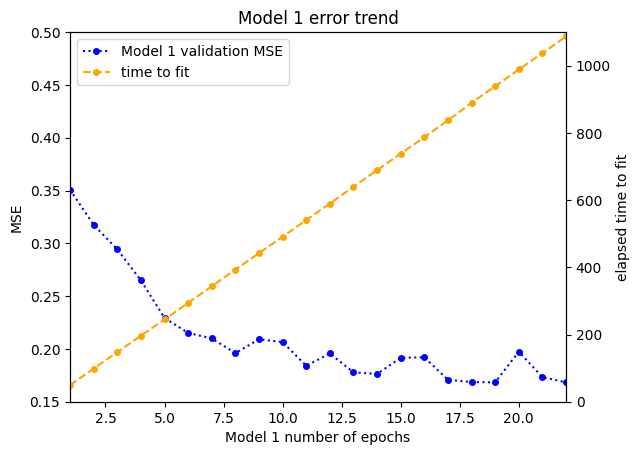

In [ ]:
axes1: plt.Axes = plt.gca()
fig = axes1.figure
axes1.set_xlabel('Model 1 number of epochs')
axes2 = axes1.twinx()
axes1.set_ylabel('MSE')
axes2.set_ylabel('elapsed time to fit')
axes2.plot(range(1,len(running_times[:22])+1), running_times[:22], markersize=4,
          color='orange', marker='o', #marker='+',
          linestyle='dashed',
          label='time to fit')
axes1.plot(range(1,len(test_losses[:22])+1), test_losses[:22], markersize=4,
          color='blue', marker='o', #marker='o',
          linestyle='dotted',
          label='Model 1 validation MSE')

axes1.set_ylim(0.15,0.5)
axes2.set_ylim(0,1100)
axes1.set_xlim(1,22)

fig.legend(loc='upper left', bbox_to_anchor=(0,0,1,1), bbox_transform=axes1.transAxes)
plt.title('Model 1 error trend')


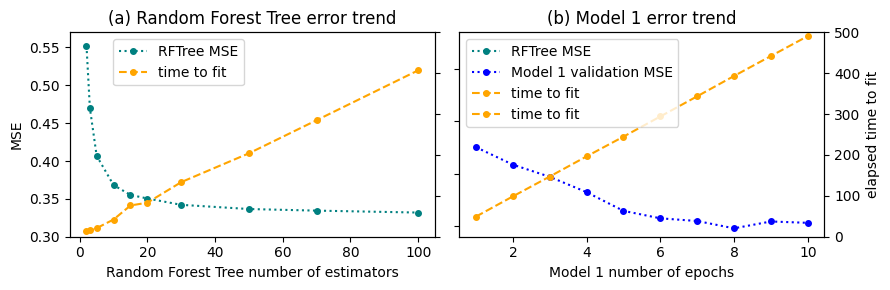

In [ ]:
plt.subplots(1,2,figsize=(9,3))

axes1: plt.Axes = plt.subplot(1,2,1) #plt.gca()
fig = axes1.figure
axes1.set_xlabel('number of estimators')
axes2 = axes1.twinx()
axes1.set_ylabel('MSE')

axes2.plot(n_estimators[1:], fittimes[1:], markersize=4,
          color='orange', marker='o', #marker='+',
          linestyle='dashed',
          label='time to fit')
axes1.plot(n_estimators[1:], MSEs[1:], markersize=4,
          color='teal', marker='o', #marker='o',
          linestyle='dotted',
          label='RFTree MSE')

axes1.set_ylim(0.3,0.57)
axes2.set_ylim(0,500)
axes2.legend(loc='upper left', bbox_to_anchor=(0.1,0,1,1), bbox_transform=axes1.transAxes)
plt.title('(a) Random Forest Tree error trend')

axes3: plt.Axes = plt.subplot(1,2,2) #plt.gca()
fig = axes3.figure
axes3.set_xlabel('Model 1 number of epochs')
axes4 = axes3.twinx()
axes4.set_ylabel('elapsed time to fit')
axes4.plot(range(1,len(running_times[:10])+1), running_times[:10], markersize=4,
          color='orange', marker='o', #marker='+',
          linestyle='dashed',
          label='time to fit')
axes3.plot(range(1,len(test_losses[:10])+1), test_losses[:10], markersize=4,
          color='blue', marker='o', #marker='o',
          linestyle='dotted',
          label='Model 1 validation MSE')

axes3.set_ylim(0.18,0.57)
axes4.set_ylim(0,500)

axes4.legend(loc='upper left', bbox_to_anchor=(0,0,1,1), bbox_transform=axes3.transAxes)
plt.title('(b) Model 1 error trend')

axes3.set_yticklabels([])
axes2.set_yticklabels([])

plt.tight_layout()


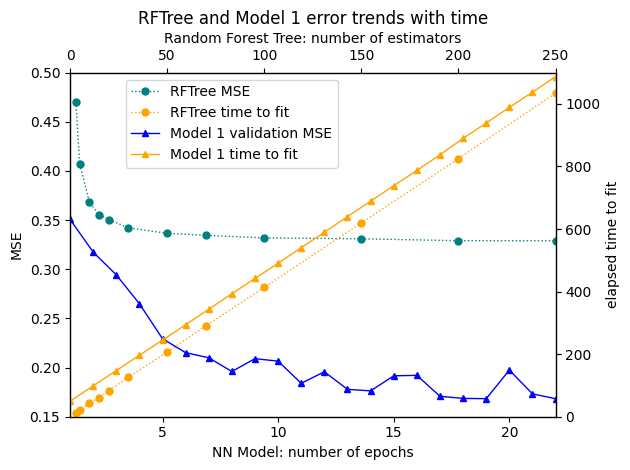

In [ ]:
axes1 = plt.gca()
fig = axes1.figure
axes1.set_xlabel('Random Forest Tree: number of estimators')
axes2 = axes1.twinx()
axes1.set_ylabel('MSE')
axes2.set_ylabel('elapsed time to fit')
axes2.plot(n_estimators[2:], fittimes[2:], markersize=5,
          color='orange', marker='o', #marker='+',
          linestyle='dotted',#'dashed',
          linewidth=1,
          label='RFTree time to fit')
axes1.plot(n_estimators[2:], MSEs[2:], markersize=5,
          color='teal', marker='o', #marker='o',
          linestyle='dotted',
          linewidth=1,
          label='RFTree MSE')

axes1.set_ylim(0.15,0.5)
axes2.set_ylim(0,1100)
axes1.set_xlim(0,250)

axes3 = axes1.twiny()
fig = axes3.figure
axes3.set_xlabel('NN Model: number of epochs')
axes4 = axes3.twinx()
axes4.plot(range(1,len(running_times[:22])+1), running_times[:22], markersize=5,
          color='orange', marker='^', #marker='+',
          # linestyle='dashed',
          linestyle='solid',
          linewidth=1,
          label='Model 1 time to fit')
axes3.plot(range(1,len(test_losses[:22])+1), test_losses[:22], markersize=5,
          color='blue', marker='^', #marker='o',
          # linestyle='dotted',
          linestyle='solid',
          linewidth=1,
          label='Model 1 validation MSE')

axes3.set_ylim(0.15,0.5)
axes4.set_ylim(0,1100)
axes3.set_xlim(1,22)

axes1.xaxis.tick_top()
axes1.xaxis.set_label_position('top')
axes2.xaxis.tick_top()
axes2.xaxis.set_label_position('top')
axes3.xaxis.tick_bottom()
axes3.xaxis.set_label_position('bottom')
axes4.xaxis.tick_bottom()
axes4.xaxis.set_label_position('bottom')

from matplotlib.ticker import MaxNLocator
axes4.xaxis.set_major_locator(MaxNLocator(steps=[2,5], integer=True))

axes4.set_yticklabels([])
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0,1,1), bbox_transform=axes3.transAxes)

plt.title('RFTree and Model 1 error trends with time')

plt.tight_layout()


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
addres

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
